Подключаем нужные библиотеки

In [1]:
# Нужные библиотеки
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data.dataloader as dl
import torchvision as tv
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt
import cv2
import os

from tqdm import tqdm

Проверяем доступность видеокарты

In [2]:
if torch.cuda.is_available():
  print("You can use cuda")
  device = torch.device("cuda")
else:
  print("You can't use cuda")
  device = torch.device("cpu")

You can't use cuda


Задаем параметры для нейросети

In [9]:
num_epochs = 20

batch_size = 60
num_workers = 0
learning_rate = 1e-3

Импортируем датасет

In [10]:
trans = transforms.Compose([transforms.ToTensor()])

train_dataset = tv.datasets.MNIST(root='./datasets', train=True, transform=trans, download=True)
test_dataset = tv.datasets.MNIST(root='./datasets', train=False, transform=trans)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:11<00:00, 892896.83it/s] 


Extracting ./datasets\MNIST\raw\train-images-idx3-ubyte.gz to ./datasets\MNIST\raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 147227.68it/s]


Extracting ./datasets\MNIST\raw\train-labels-idx1-ubyte.gz to ./datasets\MNIST\raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:02<00:00, 696596.91it/s] 


Extracting ./datasets\MNIST\raw\t10k-images-idx3-ubyte.gz to ./datasets\MNIST\raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<?, ?it/s]

Extracting ./datasets\MNIST\raw\t10k-labels-idx1-ubyte.gz to ./datasets\MNIST\raw



Это число:  3


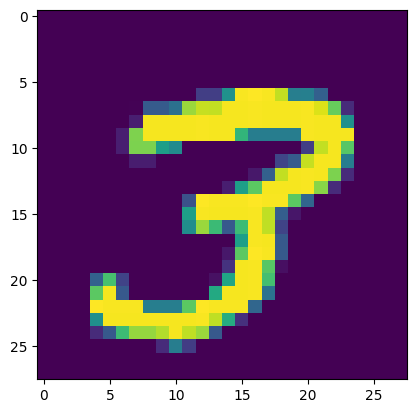

In [11]:
image = train_dataset[181]

plt.imshow(image[0].numpy()[0])
print("Это число: ", image[1])

In [12]:
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True,
                                           num_workers=num_workers)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          shuffle=False,
                                          num_workers=num_workers)

In [13]:
class ConvNS(nn.Module):
  def __init__(self):
    super(ConvNS, self).__init__()

    self.layer1 = nn.Sequential(
        nn.Conv2d(1, 32, kernel_size=5, stride=1, padding=2),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2)
    )
    self.layer2 = nn.Sequential(
        nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=2),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2)
    )
    self.drop_out = nn.Dropout()
    self.fc1 = nn.Linear(7 * 7 * 64, 1000)
    self.fc2 = nn.Linear(1000, 10)

  def forward(self, x):
    out = self.layer1(x)
    out = self.layer2(out)
    out = out.reshape(out.size(0), -1)
    out = self.drop_out(out)
    out = self.fc1(out)
    out = self.fc2(out)
    return out

In [14]:
model = ConvNS().to(device)
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [15]:
print(len(train_loader))
total_step = len(train_loader)

1000


In [16]:
loss_list = []
acc_list = []
for epoch in range(num_epochs):
    for i, (images, labels) in (pbar := tqdm(enumerate(train_loader))):
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        loss = loss_func(outputs, labels)
        loss_list.append(loss.item())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total = labels.size(0)
        _, predicted = torch.max(outputs.data, 1)
        correct = (predicted == labels).sum().item()
        acc_list.append(correct / total)

        pbar.set_description(f'Current loss: {loss.item():.4e}')

        if (i + 1) % 200 == 0 and i != 0:
          print('\nEpoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Accuracy: {:.2f}%\n'.format(epoch + 1, num_epochs, i + 1, total_step, loss.item(),(correct / total) * 100))

Current loss: 1.9406e-01: : 205it [00:07, 27.40it/s]


Epoch [1/20], Step [200/1000], Loss: 0.2127, Accuracy: 95.00%



Current loss: 2.1537e-02: : 403it [00:15, 26.63it/s]


Epoch [1/20], Step [400/1000], Loss: 0.1590, Accuracy: 95.00%



Current loss: 1.0718e-03: : 204it [00:08, 23.72it/s]


Epoch [7/20], Step [200/1000], Loss: 0.0022, Accuracy: 100.00%



Current loss: 5.4224e-02: : 403it [00:17, 23.49it/s]


Epoch [7/20], Step [400/1000], Loss: 0.0070, Accuracy: 100.00%



Current loss: 9.6211e-03: : 604it [00:26, 22.20it/s]


Epoch [7/20], Step [600/1000], Loss: 0.0048, Accuracy: 100.00%



Current loss: 2.7743e-03: : 803it [00:35, 23.53it/s]


Epoch [7/20], Step [800/1000], Loss: 0.0365, Accuracy: 98.33%



Current loss: 4.5170e-02: : 1000it [00:44, 22.70it/s]



Epoch [7/20], Step [1000/1000], Loss: 0.0452, Accuracy: 98.33%



Current loss: 3.8055e-03: : 204it [00:08, 23.79it/s]


Epoch [8/20], Step [200/1000], Loss: 0.0122, Accuracy: 100.00%



Current loss: 3.1669e-02: : 402it [00:16, 23.07it/s]


Epoch [8/20], Step [400/1000], Loss: 0.0217, Accuracy: 100.00%



Current loss: 4.7308e-02: : 603it [00:25, 20.80it/s]


Epoch [8/20], Step [600/1000], Loss: 0.0015, Accuracy: 100.00%



Current loss: 1.7838e-03: : 804it [00:34, 24.25it/s]


Epoch [8/20], Step [800/1000], Loss: 0.0042, Accuracy: 100.00%



Current loss: 7.9614e-02: : 1000it [00:42, 23.71it/s]



Epoch [8/20], Step [1000/1000], Loss: 0.0796, Accuracy: 95.00%



Current loss: 1.7937e-03: : 204it [00:08, 24.52it/s]


Epoch [9/20], Step [200/1000], Loss: 0.0026, Accuracy: 100.00%



Current loss: 1.6406e-03: : 402it [00:16, 21.85it/s]


Epoch [9/20], Step [400/1000], Loss: 0.0508, Accuracy: 98.33%



Current loss: 1.4850e-02: : 603it [00:24, 24.80it/s]


Epoch [9/20], Step [600/1000], Loss: 0.0135, Accuracy: 100.00%



Current loss: 2.8575e-03: : 804it [00:33, 24.10it/s]


Epoch [9/20], Step [800/1000], Loss: 0.0082, Accuracy: 100.00%



Current loss: 5.5281e-02: : 1000it [00:41, 24.08it/s]



Epoch [9/20], Step [1000/1000], Loss: 0.0553, Accuracy: 98.33%



Current loss: 4.3856e-02: : 204it [00:08, 23.35it/s]


Epoch [10/20], Step [200/1000], Loss: 0.0128, Accuracy: 100.00%



Current loss: 6.2855e-04: : 403it [00:18, 19.44it/s]


Epoch [10/20], Step [400/1000], Loss: 0.0094, Accuracy: 100.00%



Current loss: 8.2702e-03: : 602it [00:29, 17.00it/s]


Epoch [10/20], Step [600/1000], Loss: 0.0081, Accuracy: 100.00%



Current loss: 1.0574e-01: : 803it [00:38, 22.37it/s]


Epoch [10/20], Step [800/1000], Loss: 0.0104, Accuracy: 100.00%



Current loss: 3.0261e-02: : 1000it [00:47, 21.04it/s]



Epoch [10/20], Step [1000/1000], Loss: 0.0303, Accuracy: 98.33%



Current loss: 1.5746e-02: : 204it [00:08, 22.84it/s]


Epoch [11/20], Step [200/1000], Loss: 0.0143, Accuracy: 98.33%



Current loss: 9.6111e-04: : 402it [00:17, 23.46it/s]


Epoch [11/20], Step [400/1000], Loss: 0.0259, Accuracy: 98.33%



Current loss: 7.7774e-02: : 603it [00:26, 22.73it/s]


Epoch [11/20], Step [600/1000], Loss: 0.0016, Accuracy: 100.00%



Current loss: 2.0275e-03: : 801it [00:35, 22.95it/s]


Epoch [11/20], Step [800/1000], Loss: 0.0020, Accuracy: 100.00%



Current loss: 5.5333e-02: : 1000it [00:43, 22.82it/s]



Epoch [11/20], Step [1000/1000], Loss: 0.0553, Accuracy: 98.33%



Current loss: 3.0507e-02: : 204it [00:08, 23.90it/s]


Epoch [12/20], Step [200/1000], Loss: 0.0009, Accuracy: 100.00%



Current loss: 2.1010e-02: : 403it [00:17, 23.08it/s]


Epoch [12/20], Step [400/1000], Loss: 0.0416, Accuracy: 98.33%



Current loss: 1.4781e-04: : 604it [00:26, 22.21it/s]


Epoch [12/20], Step [600/1000], Loss: 0.0010, Accuracy: 100.00%



Current loss: 4.0639e-03: : 802it [00:34, 23.78it/s]


Epoch [12/20], Step [800/1000], Loss: 0.0086, Accuracy: 100.00%



Current loss: 7.4811e-03: : 1000it [00:43, 23.09it/s]



Epoch [12/20], Step [1000/1000], Loss: 0.0075, Accuracy: 100.00%



Current loss: 1.2679e-03: : 204it [00:08, 25.11it/s]


Epoch [13/20], Step [200/1000], Loss: 0.0061, Accuracy: 100.00%



Current loss: 1.5171e-02: : 403it [00:16, 25.50it/s]


Epoch [13/20], Step [400/1000], Loss: 0.0246, Accuracy: 100.00%



Current loss: 1.4070e-02: : 604it [00:24, 25.24it/s]


Epoch [13/20], Step [600/1000], Loss: 0.0001, Accuracy: 100.00%



Current loss: 2.6771e-03: : 802it [00:32, 25.91it/s]


Epoch [13/20], Step [800/1000], Loss: 0.0406, Accuracy: 98.33%



Current loss: 3.0543e-02: : 1000it [00:39, 25.09it/s]



Epoch [13/20], Step [1000/1000], Loss: 0.0305, Accuracy: 98.33%



Current loss: 1.5398e-02: : 204it [00:08, 25.32it/s]


Epoch [14/20], Step [200/1000], Loss: 0.0069, Accuracy: 100.00%



Current loss: 1.3905e-03: : 402it [00:15, 25.60it/s]


Epoch [14/20], Step [400/1000], Loss: 0.0004, Accuracy: 100.00%



Current loss: 2.0220e-03: : 603it [00:23, 25.90it/s]


Epoch [14/20], Step [600/1000], Loss: 0.0092, Accuracy: 100.00%



Current loss: 1.6714e-01: : 804it [00:31, 25.99it/s]


Epoch [14/20], Step [800/1000], Loss: 0.0200, Accuracy: 98.33%



Current loss: 2.1039e-02: : 1000it [00:39, 25.47it/s]



Epoch [14/20], Step [1000/1000], Loss: 0.0210, Accuracy: 98.33%



Current loss: 4.2715e-03: : 204it [00:08, 24.10it/s]


Epoch [15/20], Step [200/1000], Loss: 0.0059, Accuracy: 100.00%



Current loss: 2.5096e-02: : 402it [00:16, 25.23it/s]


Epoch [15/20], Step [400/1000], Loss: 0.0069, Accuracy: 100.00%



Current loss: 3.9695e-04: : 603it [00:24, 24.76it/s]


Epoch [15/20], Step [600/1000], Loss: 0.0009, Accuracy: 100.00%



Current loss: 2.0672e-03: : 804it [00:32, 24.85it/s]


Epoch [15/20], Step [800/1000], Loss: 0.0013, Accuracy: 100.00%



Current loss: 1.1533e-04: : 1000it [00:40, 24.81it/s]



Epoch [15/20], Step [1000/1000], Loss: 0.0001, Accuracy: 100.00%



Current loss: 1.2015e-02: : 204it [00:08, 25.45it/s]


Epoch [16/20], Step [200/1000], Loss: 0.0333, Accuracy: 98.33%



Current loss: 1.8332e-02: : 402it [00:16, 20.76it/s]


Epoch [16/20], Step [400/1000], Loss: 0.0004, Accuracy: 100.00%



Current loss: 2.6087e-04: : 603it [00:24, 25.15it/s]


Epoch [16/20], Step [600/1000], Loss: 0.0002, Accuracy: 100.00%



Current loss: 3.7662e-04: : 804it [00:32, 25.32it/s]


Epoch [16/20], Step [800/1000], Loss: 0.0452, Accuracy: 98.33%



Current loss: 1.4353e-01: : 1000it [00:40, 24.99it/s]



Epoch [16/20], Step [1000/1000], Loss: 0.1435, Accuracy: 96.67%



Current loss: 1.7555e-01: : 204it [00:07, 25.81it/s]


Epoch [17/20], Step [200/1000], Loss: 0.0026, Accuracy: 100.00%



Current loss: 8.5131e-03: : 402it [00:15, 25.53it/s]


Epoch [17/20], Step [400/1000], Loss: 0.0028, Accuracy: 100.00%



Current loss: 9.8139e-04: : 603it [00:23, 25.10it/s]


Epoch [17/20], Step [600/1000], Loss: 0.0002, Accuracy: 100.00%



Current loss: 8.5573e-04: : 804it [00:31, 26.26it/s]


Epoch [17/20], Step [800/1000], Loss: 0.0001, Accuracy: 100.00%



Current loss: 1.4877e-04: : 1000it [00:39, 25.46it/s]



Epoch [17/20], Step [1000/1000], Loss: 0.0001, Accuracy: 100.00%



Current loss: 1.7466e-03: : 204it [00:07, 26.10it/s]


Epoch [18/20], Step [200/1000], Loss: 0.0008, Accuracy: 100.00%



Current loss: 7.5111e-02: : 402it [00:15, 25.95it/s]


Epoch [18/20], Step [400/1000], Loss: 0.0025, Accuracy: 100.00%



Current loss: 9.1113e-04: : 603it [00:23, 23.79it/s]


Epoch [18/20], Step [600/1000], Loss: 0.0007, Accuracy: 100.00%



Current loss: 1.1896e-03: : 804it [00:32, 25.13it/s]


Epoch [18/20], Step [800/1000], Loss: 0.0405, Accuracy: 96.67%



Current loss: 3.5264e-04: : 1000it [00:40, 24.81it/s]



Epoch [18/20], Step [1000/1000], Loss: 0.0004, Accuracy: 100.00%



Current loss: 4.7893e-05: : 204it [00:08, 23.92it/s]


Epoch [19/20], Step [200/1000], Loss: 0.0916, Accuracy: 96.67%



Current loss: 1.2701e-02: : 402it [00:17, 22.25it/s]


Epoch [19/20], Step [400/1000], Loss: 0.0017, Accuracy: 100.00%



Current loss: 4.5735e-03: : 603it [00:25, 22.83it/s]


Epoch [19/20], Step [600/1000], Loss: 0.0791, Accuracy: 96.67%



Current loss: 3.2355e-02: : 804it [00:34, 23.48it/s]


Epoch [19/20], Step [800/1000], Loss: 0.0054, Accuracy: 100.00%



Current loss: 2.8491e-03: : 1000it [00:42, 23.30it/s]



Epoch [19/20], Step [1000/1000], Loss: 0.0028, Accuracy: 100.00%



Current loss: 5.8262e-04: : 204it [00:08, 25.38it/s]


Epoch [20/20], Step [200/1000], Loss: 0.0081, Accuracy: 100.00%



Current loss: 1.6535e-02: : 402it [00:16, 24.51it/s]


Epoch [20/20], Step [400/1000], Loss: 0.0069, Accuracy: 100.00%



Current loss: 1.3876e-01: : 603it [00:24, 24.86it/s]


Epoch [20/20], Step [600/1000], Loss: 0.0444, Accuracy: 98.33%



Current loss: 3.1202e-02: : 804it [00:32, 24.63it/s]


Epoch [20/20], Step [800/1000], Loss: 0.0757, Accuracy: 96.67%



Current loss: 1.2872e-02: : 1000it [00:40, 24.97it/s]


Epoch [20/20], Step [1000/1000], Loss: 0.0129, Accuracy: 98.33%



Проверка точности нс

In [17]:
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Test Accuracy {} %'.format((correct / total) * 100))

Test Accuracy 99.26 %


In [18]:
loaded_model = ConvNS()

In [19]:
# Сохранение модели
model_save_path = 'mnist_convnet.pth'
torch.save(model.state_dict(), model_save_path)
print(f"Model saved to {model_save_path}")

Model saved to mnist_convnet.pth


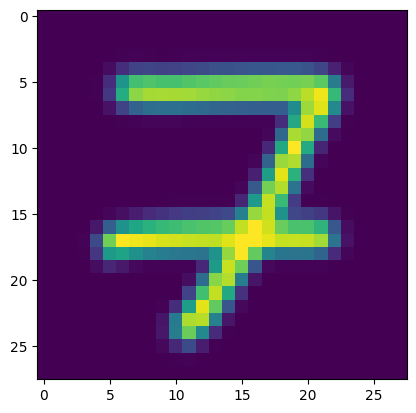

In [ ]:
test_img = cv2.imread('images/img_is_7.png', cv2.IMREAD_GRAYSCALE)
test_img = cv2.resize(test_img, (28, 28), interpolation=cv2.INTER_AREA)
# Инвертируем картинку
test_img = cv2.bitwise_not(test_img)
plt.imshow(test_img)

In [ ]:
test_img = np.expand_dims(test_img, axis=0)
test_img = np.expand_dims(test_img, axis=0)
# Нормальзуем данные
test_img = test_img.astype(np.float32) / 255.0
#test_img = test_img.astype(np.float32)
print(test_img.shape)

(1, 1, 28, 28)


In [ ]:
torch_img = torch.from_numpy(test_img).to(device)
test_model = model(torch_img).to(device)

In [ ]:
F.softmax(test_model.to("cpu")).detach().numpy().argmax()

<ipython-input-16-48ce3b006de8>:1: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  F.softmax(test_model.to("cpu")).detach().numpy().argmax()


7